In [1]:
#Run this cell to set up imports

from IPython.display import display, Math
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

# Time Series- Homework 1
## Due Date: Monday, February 10th, 11:59 P.M.

# Scoring Breakdown (Undergraduate)
|Question|Points|
|---|---|
|1a|4|
|1b|4|
|1c|2|
|1d|4|
|1e|2|
|1f|2|
|1g|2|
|1h|3|
|2a|2|
|2b|4|
|2c|6|
|2d|4|
|2e|4|
|3a|5|
|3b|5|
|4a|4|
|4b|4|
|4c|4|
|4d|3|
|4e|2|
|**Total**|75|

In [2]:
# Load dataset
df = pd.read_csv("CAPOP.csv")

# Drop the 2024 data point before fitting the model
df = df[df["observation_date"] != "2024-01-01"]

# Extract the dependent variable (population)
y = df["CAPOP"].values

# Define independent variable as sequential index (like in your provided format)
n = len(y)
x = np.arange(1, n + 1)  # Sequential index from 1 to n
X = np.column_stack([np.ones(n), x])  # Add intercept column

# Print the first few rows for validation
y[:5], X[:5]

(array([1490., 1550., 1623., 1702., 1792.]),
 array([[1., 1.],
        [1., 2.],
        [1., 3.],
        [1., 4.],
        [1., 5.]]))

## Question 1a) 

To the observed data (from 1900 to 2023), fit the model:

$$y_t = \beta_0 + \beta_1 t + \epsilon_t \quad \text{with} \quad \epsilon_t \overset{\text{i.i.d}}{\sim} N(0, \sigma^2) \quad (1)$$

Provide point estimates for $\beta_0$, $\beta_0$ along with appropriate uncertainty intervals. Interpret your point estimates and explain why they make sense

In [3]:
# Fit the OLS regression model
linmod = sm.OLS(y, X).fit()

# Extract parameter estimates
beta_0, beta_1 = linmod.params

# Print the model summary
print(linmod.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     4401.
Date:                Sat, 03 May 2025   Prob (F-statistic):           1.41e-97
Time:                        23:17:36   Log-Likelihood:                -1126.9
No. Observations:                 124   AIC:                             2258.
Df Residuals:                     122   BIC:                             2263.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4327.5370    389.897    -11.099      0.0

In [4]:
# Compute 95% confidence intervals
conf_int = linmod.conf_int()
beta_0_ci = conf_int[0]  # CI for intercept
beta_1_ci = conf_int[1]  # CI for slope
# Print the results
print(f"Estimated β₀ (Intercept): {beta_0:.3f}")
print(f"95% Confidence Interval for β₀: ({beta_0_ci[0]:.3f}, {beta_0_ci[1]:.3f})\n")

print(f"Estimated β₁ (Slope): {beta_1:.3f}")
print(f"95% Confidence Interval for β₁: ({beta_1_ci[0]:.3f}, {beta_1_ci[1]:.3f})\n")

Estimated β₀ (Intercept): -4327.537
95% Confidence Interval for β₀: (-5099.378, -3555.696)

Estimated β₁ (Slope): 359.142
95% Confidence Interval for β₁: (348.425, 369.858)



## Interpretation:

The slope $\beta_1$ has an estimated value of 359.14. The slope indicates that the population increases by approximately 359,142 people per year. The confidence interval suggests that the true annual growth rate is likely between 348,425 and 369,858 people per year. 
The estimated intercept $\beta_0$ is -4,327.54, which would theoretically represent the population at year 0 AD. However, since our dataset only covers the years 1900 to 2023, this intercept is an extrapolation far outside the observed range. In reality, population growth is not strictly linear over long periods, so interpreting the intercept as a literal estimate of past population is not meaningful. Instead, it should be understood as a necessary mathematical component of the linear model, ensuring a proper fit within the observed data range.

# Question 1b)

Along with a plot of the observed dataset, plot lines corresponding to 100 samples 
from the posterior distribution of $(\beta_0, \beta_1)$ 
(under the prior $ \beta_0, \beta_1, \log \sigma \overset{\text{i.i.d}}{\sim} \text{unif}(-C, C) $ for a very large $C$. 
Comment on the range of uncertainty revealed in this plot.

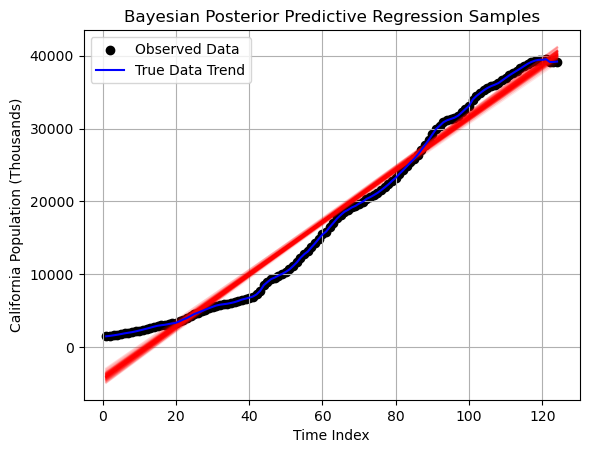

In [5]:
# Number of desired posterior samples
N = 2000
rng = np.random.default_rng()

# Generate posterior samples using normal approximation
samples_normalposterior = rng.multivariate_normal(mean=linmod.params, cov=linmod.cov_params(), size=N)

# Convert to t-distribution
demean_samples_normalposterior = samples_normalposterior - np.array(linmod.params)
chirvs = rng.chisquare(df=n-2, size=N)  # Chi-square distributed samples

# Adjust posterior samples to follow t-distribution
samples_tposterior = np.zeros((N, 2))
for r in range(N):
    samples_tposterior[r] = linmod.params + (demean_samples_normalposterior[r] / np.sqrt(chirvs[r] / (n-2)))

# Generate new x-values for prediction
x_vals = np.linspace(1, n, 100)  # Use the correct sequential time index
X_pred = np.column_stack([np.ones(len(x_vals)), x_vals])  # Add intercept column


# Plot observed data
plt.scatter(x, y, color="black", label="Observed Data")

# Plot regression lines from posterior samples
for beta_sample in samples_normalposterior[:100]:  # Draw 100 regression lines
    y_sample = np.dot(X_pred, beta_sample)
    plt.plot(x_vals, y_sample, color="red", alpha=0.1)  # Low opacity for multiple lines

# Overlay the observed data trend
plt.plot(x, y, color="blue", label="True Data Trend")

# Labels and Title
plt.xlabel("Time Index")
plt.ylabel("California Population (Thousands)")
plt.title("Bayesian Posterior Predictive Regression Samples")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

## Interpretation:

The range of uncertainty in the plot is captured by the spread of the red posterior regression lines. This spread reflects the variability in the estimated parameters $\beta_0$ and $\beta_1$, showing how different plausible fits arise from the posterior distribution. The wider dispersion in earlier years suggests greater uncertainty in predictions for lower time indices, which is expected due to the limited historical data at the start. Additionally, the comparison between the normal and $t$-distributed posteriors indicates that the latter introduces slightly more variance, accounting for potential deviations from normality.

# Question 1c)

Based on model (1), provide a point estimate along with appropriate uncertainty quantification for the Resident Annual Population of California for the year 2024.

In [6]:
# Define the time index corresponding to 2024
time_2024 = np.array([1, n + 1])  # Using the sequential index (n + 1 is the next time step)

# Compute the point estimate for 2024
point_estimate = np.dot(time_2024, linmod.params)

# Compute predictive uncertainty using t-distributed posterior samples
pred_samples = np.dot(time_2024, samples_tposterior.T)  
lower_bound, upper_bound = np.percentile(pred_samples, [2.5, 97.5])  # 95% credible interval

# Print results
print(f"Point Estimate for 2024: {point_estimate:.2f}")
print(f"95% Credible Interval: ({lower_bound:.2f}, {upper_bound:.2f})")

Point Estimate for 2024: 40565.19
95% Credible Interval: (39792.89, 41328.64)


# Question 1d)

To the observed data (from 1900 to 2023), fit the model:

$$\log y_t = \beta_0 + \beta_1 t + \epsilon_t \quad \text{with} \quad \epsilon_t \overset{\text{i.i.d}}{\sim} N(0, \sigma^2) \quad (2)$$

Provide point estimates for $\beta_0$ and $\beta_1$ along with appropriate uncertainty intervals. Interpret your point estimates and explain why they make sense.


In [7]:
# Transform the dependent variable (log transformation)
log_y = np.log(y)

# Fit the new OLS regression model
linmod_log = sm.OLS(log_y, X).fit()

# Extract parameter estimates
beta_0_log, beta_1_log = linmod_log.params

# Compute 95% confidence intervals
conf_int_log = linmod_log.conf_int()
beta_0_ci_log = conf_int_log[0]  # CI for intercept
beta_1_ci_log = conf_int_log[1]  # CI for slope

# Print the model summary
print(linmod_log.summary())

# Print results
print(f"Estimated β₀ (Intercept): {beta_0_log:.3f}")
print(f"95% Confidence Interval for β₀: ({beta_0_ci_log[0]:.3f}, {beta_0_ci_log[1]:.3f})\n")

print(f"Estimated β₁ (Slope): {beta_1_log:.3f}")
print(f"95% Confidence Interval for β₁: ({beta_1_ci_log[0]:.3f}, {beta_1_ci_log[1]:.3f})\n")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     2408.
Date:                Sat, 03 May 2025   Prob (F-statistic):           3.50e-82
Time:                        23:17:36   Log-Likelihood:                 12.674
No. Observations:                 124   AIC:                            -21.35
Df Residuals:                     122   BIC:                            -15.71
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.7216      0.040    194.024      0.0

## Interpretation:

The estimated intercept $\beta_0$ is 7.722 This represents the estimated value of $\log y_t$ when $t = 0$. Since the model is in logarithmic form, exponentiating this value gives an estimate of the initial population at $t = 0$, though it is outside the observed range. The slope $\beta_0$ has an estimated value 0.027. This represents the estimated growth rate in log-space. Interpreting in exponential terms, since the model assumes:

$$\log y_t = \beta_0 + \beta_1 t + \epsilon_t$$ exponentiating both sides:
$$y_t = e^{\beta_0} e^{\beta_1 t}$$ which means the population grows exponentially at a rate of approximately
$$e^{0.027} - 1 \approx 2.74\% \text{ per year} $$ This estimate makes sense given that the data follows an upward growth trend.


# Question 1e)

For the model (2) (and under the prior $\beta_0, \beta_1 \log \sigma \text{ i.i.d } \sim \text{ unif}(-C, C)$ for a very large $C$), calculate the posterior probability that $\beta_1$ is larger than 0.03.

In [8]:
# Number of posterior samples
N = 2000

# Generate posterior samples using normal approximation
samples_normalposterior_log = rng.multivariate_normal(mean=linmod_log.params, cov=linmod_log.cov_params(), size=N)

# Convert to t-distribution
demean_samples_normalposterior_log = samples_normalposterior_log - np.array(linmod_log.params)
chirvs_log = rng.chisquare(df=n-2, size=N)  # Chi-square distributed samples

# Adjust posterior samples to follow t-distribution
samples_tposterior_log = np.zeros((N, 2))
for r in range(N):
    samples_tposterior_log[r] = linmod_log.params + demean_samples_normalposterior_log[r] / np.sqrt(chirvs_log[r] / (n-2))

# Generate new x-values for prediction
x_vals = np.linspace(1, n, 100)  # Sequential index for time
X_pred = np.column_stack([np.ones(len(x_vals)), x_vals])  # Add intercept column

# Compute the posterior probability that β1 > 0.03
prob_beta1_greater_003 = np.mean(samples_tposterior_log[:, 1] > 0.03)

# Print the result
print(f"Posterior Probability that β1 > 0.03: {prob_beta1_greater_003:.4f}")

Posterior Probability that β1 > 0.03: 0.0000


# Question 1f)

Based on model (2), provide a point estimate along with appropriate uncertainty quantification for the Resident Annual Population of California for the year 2024.

In [9]:
# Define the time index corresponding to 2024
time_2024 = np.array([[1, n + 1]])  # Intercept term + sequential index

# Compute the point estimate for 2024 using Model 2 (log-space)
log_point_estimate = np.dot(time_2024, linmod_log.params)  # Predict in log-space
point_estimate = np.exp(log_point_estimate)  # Convert back to original scale

# Compute predictive uncertainty using posterior samples
log_pred_samples = np.dot(time_2024, samples_tposterior_log.T)  # Log-space predictions
pred_samples = np.exp(log_pred_samples)  # Convert back to original scale

# Compute 95% credible interval
lower_bound, upper_bound = np.percentile(pred_samples, [2.5, 97.5])

# Print results
print(f"Point Estimate for 2024: {point_estimate[0]:.2f}")
print(f"95% Credible Interval: ({lower_bound:.2f}, {upper_bound:.2f})")

Point Estimate for 2024: 66909.89
95% Credible Interval: (62058.89, 72236.57)


# Question 1g)

To the observed data (from 1900 to 2023), fit the model:

$$\log y_t = \beta_0 + \beta_1 t + \beta_2 t^2 + \epsilon_t, \quad \text{with} \quad \epsilon_t \overset{\text{i.i.d}}{\sim} \mathcal{N}(0, \sigma^2) \quad (3)$$

Based on the fitted model, provide a point estimate along with appropriate uncertainty quantification for the Resident Annual Population of California for the year 2024.

In [10]:
# Prepare data
X = np.column_stack((np.ones(len(x)), x, x**2))  # Add quadratic term
y_log = np.log(y)  # Log transformation

# Fit quadratic model
linmod_quad = sm.OLS(y_log, X).fit()

# Extract predictions
y_pred_log = linmod_quad.predict(X)
y_pred = np.exp(y_pred_log)  # Convert back to original scale

# Define the time index for 2024 (sequential index n + 1)
t_2024 = np.array([[1, (n + 1), (n + 1) ** 2]])  # Intercept, linear term, quadratic term

# Compute the point estimate for 2024 using Model 3 (Quadratic Model)
log_point_estimate = np.dot(t_2024, linmod_quad.params)  # Predict in log-space
point_estimate = np.exp(log_point_estimate)  # Convert back to original scale

# Generate posterior predictive samples
samples_normal_posterior = rng.multivariate_normal(
    mean=linmod_quad.params, cov=linmod_quad.cov_params(), size=2000
)

# Compute predictive uncertainty using posterior samples
log_pred_samples = np.dot(t_2024, samples_normal_posterior.T)  # Predict in log-space
pred_samples = np.exp(log_pred_samples)  # Convert back to original scale

# Compute 95% credible interval
lower_bound, upper_bound = np.percentile(pred_samples, [2.5, 97.5])

# Display results using print statements
print(f"Point Estimate for 2024: {point_estimate.item():.2f}")
print(f"95% Credible Interval: ({lower_bound:.2f}, {upper_bound:.2f})")

Point Estimate for 2024: 40933.48
95% Credible Interval: (40041.49, 41887.65)


# Question 1h)

Which of the three models (1), (2), (3) would you recommend for this dataset and why? Also report which of your predictions for the 2024 population is closest to the actual observed value

In [11]:
# Load the full dataset
df_full = pd.read_csv("CAPOP.csv")

# Extract the 2024 data point
pop_2024 = df_full[df_full["observation_date"] == "2024-01-01"]["CAPOP"].values

# Print the 2024 population value
if len(pop_2024) > 0:
    print(f"Actual Resident Annual Population of California in 2024: {pop_2024[0]:,.2f}")
else:
    print("No 2024 data point found in the dataset.")

Actual Resident Annual Population of California in 2024: 39,431.26


## Conclusion:

I would recommend Model 1 despite Model 3 appearing to fit the dataset best based on visualizations and having the highest $R^2$. While Model 3 shows a better fit to historical data, its prediction for 2024 was less accurate than Model 1’s, suggesting possible overfitting. Model 3 likely has lower bias but higher variance, making it sensitive to fluctuations in the data. In contrast, Model 1, being a simple linear regression, has higher bias but lower variance, making it more stable for forecasting. Given the dataset’s linear trend, a simpler model like Model 1 aligns better with the underlying pattern, making it the more reliable choice for prediction.

## Question 2a)

Is the linear model:
$$
\log y_t = \beta_0 + \beta_1 t + \epsilon_t, \quad \text{with} \quad \epsilon_t \overset{\text{i.i.d.}}{\sim} N(0, \sigma^2) \tag{4}
$$
appropriate for this dataset? Why or why not? 

In [12]:
liq_data = pd.read_csv("liquor_data.csv")

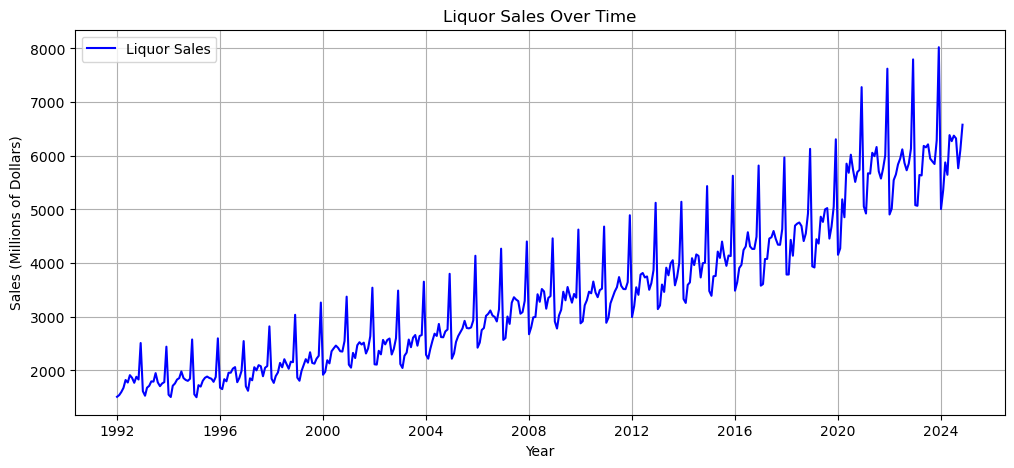

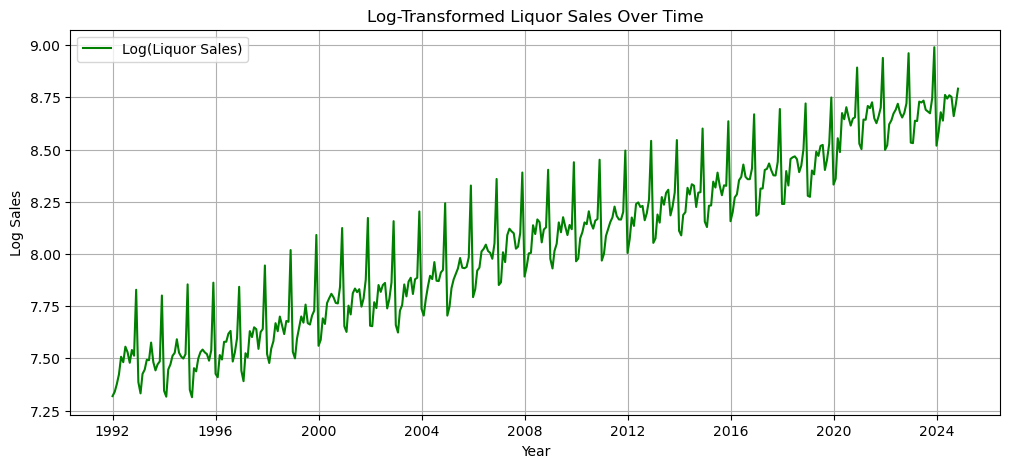

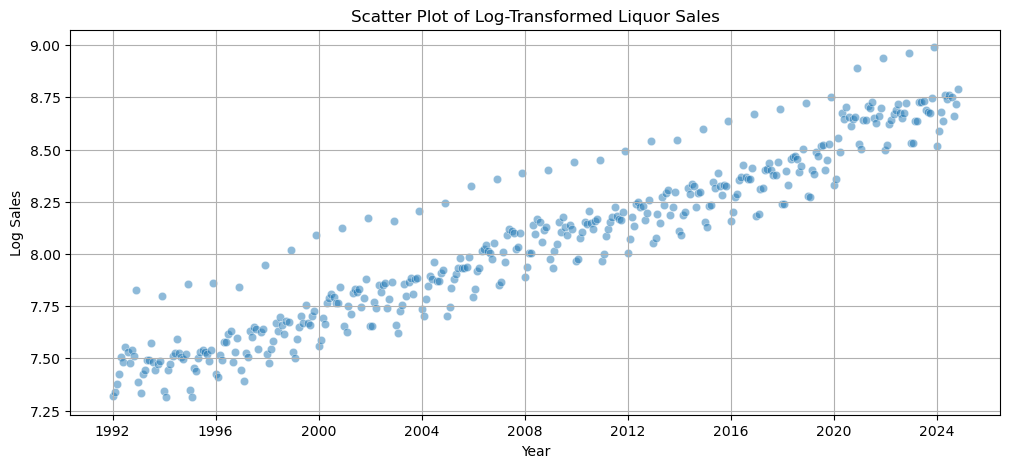

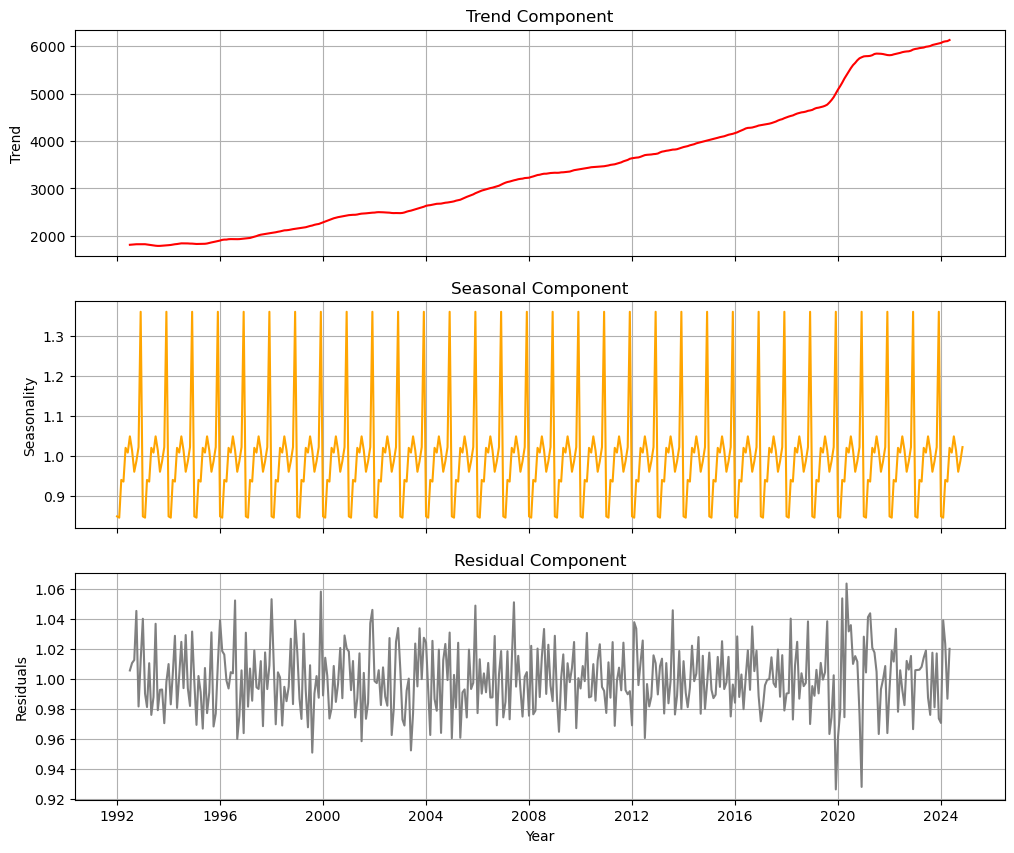

In [13]:
# Convert observation_date to datetime
liq_data["observation_date"] = pd.to_datetime(liq_data["observation_date"])

# Sort data by date (just in case)
liq_data = liq_data.sort_values("observation_date")

# Rename columns for easier handling
liq_data.rename(columns={"MRTSSM4453USN": "sales"}, inplace=True)

# Create log-transformed sales
liq_data["log_sales"] = np.log(liq_data["sales"])

# Plot 1: Original Time Series
plt.figure(figsize=(12, 5))
plt.plot(liq_data["observation_date"], liq_data["sales"], label="Liquor Sales", color='blue')
plt.xlabel("Year")
plt.ylabel("Sales (Millions of Dollars)")
plt.title("Liquor Sales Over Time")
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: Log-Transformed Time Series
plt.figure(figsize=(12, 5))
plt.plot(liq_data["observation_date"], liq_data["log_sales"], label="Log(Liquor Sales)", color='green')
plt.xlabel("Year")
plt.ylabel("Log Sales")
plt.title("Log-Transformed Liquor Sales Over Time")
plt.legend()
plt.grid(True)
plt.show()

# Plot 3: Scatter Plot of Log(Sales) vs. Time
plt.figure(figsize=(12, 5))
sns.scatterplot(x=liq_data["observation_date"], y=liq_data["log_sales"], alpha=0.5)
plt.xlabel("Year")
plt.ylabel("Log Sales")
plt.title("Scatter Plot of Log-Transformed Liquor Sales")
plt.grid(True)
plt.show()

# Seasonal decomposition
decomp = seasonal_decompose(liq_data["sales"], model="multiplicative", period=12)

# Plot 4: Seasonal Decomposition
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

axes[0].plot(liq_data["observation_date"], decomp.trend, label="Trend", color='red')
axes[0].set_ylabel("Trend")
axes[0].set_title("Trend Component")
axes[0].grid(True)

axes[1].plot(liq_data["observation_date"], decomp.seasonal, label="Seasonality", color='orange')
axes[1].set_ylabel("Seasonality")
axes[1].set_title("Seasonal Component")
axes[1].grid(True)

axes[2].plot(liq_data["observation_date"], decomp.resid, label="Residuals", color='gray')
axes[2].set_ylabel("Residuals")
axes[2].set_title("Residual Component")
axes[2].grid(True)

plt.xlabel("Year")
plt.show()

## Conclusion/Solution:

I've provided visualizations of the data to support my analysis. The log transformation reduces variance and stabilizes fluctuations, making the trend more linear, which is useful for simple linear regression. However, since the data exhibits seasonality, incorporating a sinusoidal function might better capture these periodic effects. Additionally, the curvature in the trend around 2020 suggests that adding a quadratic term could improve the fit.

That said, the overall direction of sales is steadily increasing, indicating that a linear model effectively captures the long-term trend. In contrast, if fluctuations grow too large over time, the assumption of constant variance (homoskedasticity) may no longer hold. For example, the structural break in 2020 suggests the model may not fully capture sudden market shifts. However, one-off anomalies shouldn’t dictate model selection if they are unlikely to repeat.

Given that the data follows a consistent seasonal upward trend and log transformation smooths this trend in a linearized fashion, I conclude that a linear model fits the data well in most cases and remains a strong choice overall.

## 2b)

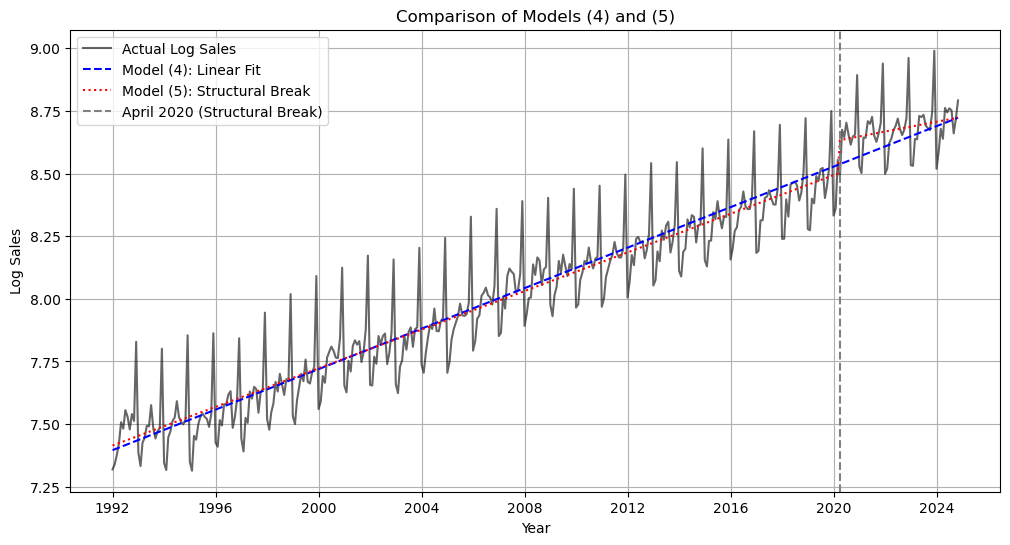

,observation_date,sales,log_sales,I_t_geq_t0,t,t_I_t_geq_t0,fitted_4,fitted_5
0,1992-01-01,1509,7.319202,0,0,0,7.396043,7.414455
1,1992-02-01,1541,7.340187,0,1,0,7.399410,7.417666
2,1992-03-01,1597,7.375882,0,2,0,7.402777,7.420876
3,1992-04-01,1675,7.423568,0,3,0,7.406144,7.424087
4,1992-05-01,1822,7.507690,0,4,0,7.409510,7.427298
...,...,...,...,...,...,...,...,...
390,2024-07-01,6375,8.760139,1,390,390,8.709088,8.716264
391,2024-08-01,6324,8.752107,1,391,391,8.712455,8.717890
392,2024-09-01,5768,8.660081,1,392,392,8.715822,8.719517
393,2024-10-01,6104,8.716700,1,393,393,8.719189,8.721143


In [14]:
# Convert observation_date to datetime
liq_data["observation_date"] = pd.to_datetime(liq_data["observation_date"])

# Sort data by date (just in case)
liq_data = liq_data.sort_values("observation_date")

# Rename columns for easier handling
liq_data.rename(columns={"MRTSSM4453USN": "sales"}, inplace=True)

# Create log-transformed sales
liq_data["log_sales"] = np.log(liq_data["sales"])

# Define the structural break time (April 2020)
t0 = pd.to_datetime("2020-04-01")

# Create indicator variables
liq_data["I_t_geq_t0"] = (liq_data["observation_date"] >= t0).astype(int)
liq_data["t"] = np.arange(len(liq_data))  # Time index
liq_data["t_I_t_geq_t0"] = liq_data["I_t_geq_t0"] * liq_data["t"]

# Model (4) - Simple Linear Regression
X4 = sm.add_constant(liq_data["t"])  # Add intercept
model_4 = sm.OLS(liq_data["log_sales"], X4).fit()

# Model (5) - Structural Break Regression
X5 = sm.add_constant(liq_data[["t", "I_t_geq_t0", "t_I_t_geq_t0"]])  # Add intercept & indicators
model_5 = sm.OLS(liq_data["log_sales"], X5).fit()

# Predictions
liq_data["fitted_4"] = model_4.predict(X4)
liq_data["fitted_5"] = model_5.predict(X5)

# Plot the fitted models along with original data
plt.figure(figsize=(12, 6))
plt.plot(liq_data["observation_date"], liq_data["log_sales"], label="Actual Log Sales", color="black", alpha=0.6)
plt.plot(liq_data["observation_date"], liq_data["fitted_4"], label="Model (4): Linear Fit", color="blue", linestyle="dashed")
plt.plot(liq_data["observation_date"], liq_data["fitted_5"], label="Model (5): Structural Break", color="red", linestyle="dotted")

plt.axvline(t0, color="gray", linestyle="--", label="April 2020 (Structural Break)")
plt.xlabel("Year")
plt.ylabel("Log Sales")
plt.title("Comparison of Models (4) and (5)")
plt.legend()
plt.grid(True)
plt.show()

# Display model summaries for comparison
model_4.summary(), model_5.summary()
liq_data

## 2c)

In [15]:
# Given posterior mean and covariance matrix from fitted model
beta_posterior_mean = model_5.params  # Extract posterior mean for model 5
beta_posterior_cov = model_5.cov_params()  # Extract covariance matrix

# Number of posterior samples
N = 2000

# Generate posterior samples using normal approximation
rng = np.random.default_rng()
samples_normalposterior = rng.multivariate_normal(beta_posterior_mean, beta_posterior_cov, size=N)

# Convert to t-distribution adjustment
demean_samples_normalposterior = samples_normalposterior - np.array(beta_posterior_mean)
chi_rvs = rng.chisquare(df=len(beta_posterior_mean)-2, size=N)  # Chi-square distributed samples

# Adjust posterior samples to follow t-distribution
samples_tposterior = np.zeros_like(samples_normalposterior)
for r in range(N):
    samples_tposterior[r] = beta_posterior_mean + demean_samples_normalposterior[r] / np.sqrt(chi_rvs[r] / (N-2))

# Extract posterior samples for beta_3
beta_3_samples = samples_tposterior[:, 3]

# Compute P(beta_3 < 0)
prob_beta3_less_than_0 = np.mean(beta_3_samples < 0)

# Define t_0 corresponding to April 2020 (assumed known)
t_0 = 2020 - 1900 + 4/12  # Convert year and month to decimal time index

# Compute posterior samples for beta_2 + beta_3 * t_0
beta_2_samples = samples_tposterior[:, 2]
beta2_plus_beta3_t0_samples = beta_2_samples + beta_3_samples * t_0

# Compute P(beta_2 + beta_3 * t_0 > 0)
prob_beta2_plus_beta3_t0_greater_0 = np.mean(beta2_plus_beta3_t0_samples > 0)

# Display results
print(f"Solution: P(beta_3 < 0): {prob_beta3_less_than_0:.4f}")
print(f"Solution: P(beta_2 + beta_3 * t_0 > 0): {prob_beta2_plus_beta3_t0_greater_0:.4f}")


Solution: P(beta_3 < 0): 0.5280
Solution: P(beta_2 + beta_3 * t_0 > 0): 0.5275


## 1d)

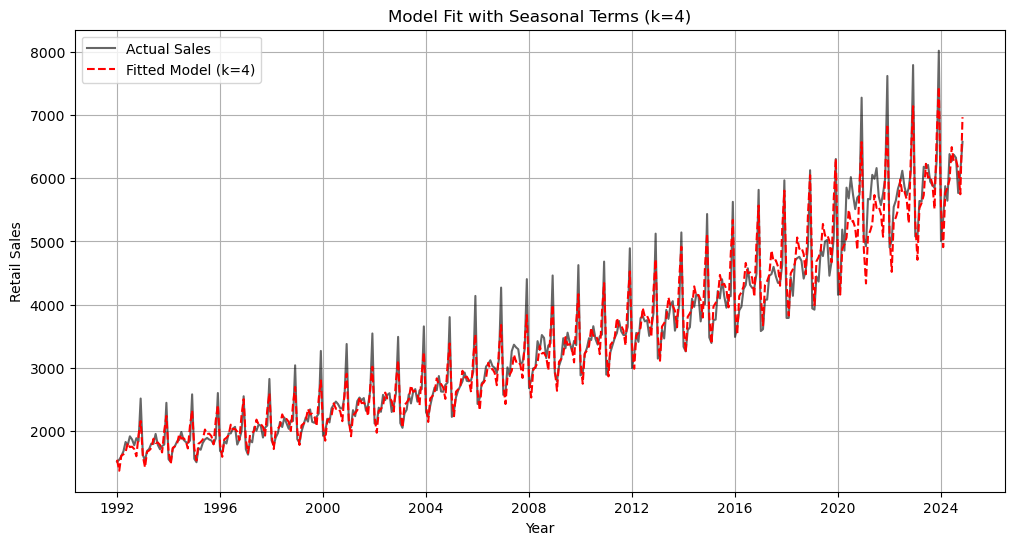

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_sales   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     1214.
Date:                Sat, 03 May 2025   Prob (F-statistic):          6.29e-290
Time:                        23:17:39   Log-Likelihood:                 505.78
No. Observations:                 395   AIC:                            -987.6
Df Residuals:                     383   BIC:                            -939.8
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            7.4163      0.013    590.465      0.000       7.392       7.441
t                0.0031      0.000     17.281      0.000       0.003       0.003
I_t_geq_t0      -0.0506      0.019     -2.690      0.007      -0.088      -0.014
t_I_t_geq_t0     0.0003      0.000      1.844      0.066   -2.29e-05       0.001
cos_1            0.0084      0.005      1.718      0.087      -0.001       0.018
cos_2            0.0825      0.005     16.952      0.000       0.073       0.092
cos_3            0.0704      0.005     14.475      0.000       0.061       0.080
cos_4            0.0599      0.005     12.306      0.000       0.050       0.069
sin_1           -0.0545      0.005    -11.223      0.000      -0.064      -0.045
sin_2           -0.0328      0.005     -6.765      0.000      -0.042      -0.023
sin_3           -0.0319      0.005     -6.566      0.000      -0.041      -0.022
sin_4           -0.0123      0.005     -2.535      0.012      -0.022      -0.003
==============================================================================
Omnibus:                        8.663   Durbin-Watson:                   2.675
Prob(Omnibus):                  0.013   Jarque-Bera (JB):                5.535
Skew:                           0.125   Prob(JB):                       0.0628
Kurtosis:                       2.477   Cond. No.                     1.95e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.95e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [16]:
# Convert date column to datetime if necessary
liq_data["observation_date"] = pd.to_datetime(liq_data["observation_date"])

# Define the structural break time (April 2020)
t_0 = 2020 - 1900 + 4 / 12  # Convert to decimal time index

# Define time index
liq_data["t"] = np.arange(1, len(liq_data) + 1)

# Define indicator variables for structural break
liq_data["I_t_geq_t0"] = (liq_data["t"] >= t_0).astype(int)
liq_data["t_I_t_geq_t0"] = liq_data["t"] * liq_data["I_t_geq_t0"]

# Define seasonal components for k=4
k = 4
for i in range(1, k + 1):
    liq_data[f"cos_{i}"] = np.cos(2 * np.pi * i * liq_data["t"] / 12)
    liq_data[f"sin_{i}"] = np.sin(2 * np.pi * i * liq_data["t"] / 12)

# Define the design matrix
X_columns = ["t", "I_t_geq_t0", "t_I_t_geq_t0"] + [f"cos_{i}" for i in range(1, k + 1)] + [f"sin_{i}" for i in range(1, k + 1)]
X = sm.add_constant(liq_data[X_columns])

# Fit the model
model_seasonal = sm.OLS(liq_data["log_sales"], X).fit()

# Make predictions
liq_data["fitted_seasonal"] = np.exp(model_seasonal.predict(X))  # Convert back from log-scale

# Plot observed vs. fitted values
plt.figure(figsize=(12, 6))
plt.plot(liq_data["observation_date"], liq_data["sales"], label="Actual Sales", color="black", alpha=0.6)
plt.plot(liq_data["observation_date"], liq_data["fitted_seasonal"], label=f"Fitted Model (k={k})", color="red", linestyle="dashed")

plt.xlabel("Year")
plt.ylabel("Retail Sales")
plt.title(f"Model Fit with Seasonal Terms (k={k})")
plt.legend()
plt.grid(True)
plt.show()

# Print model summary
model_seasonal.summary()

## Conclusion & Reasoning:

$k = 4$ provides a strong fit, statistically significant seaonsal terms, and good model selection metrics. The adjusted $R^2$ value is 0.971, which indicates that the model explains 97.1% of the variance in log-transformed sales. This is a strong indication that the seasonal components (up to $k=4$) are capturing the underlying trend well. The cosine and sine terms up to $k=4$ have highly significant p-values that are all close to 0.000 indicating they're highly significant.

## 2e

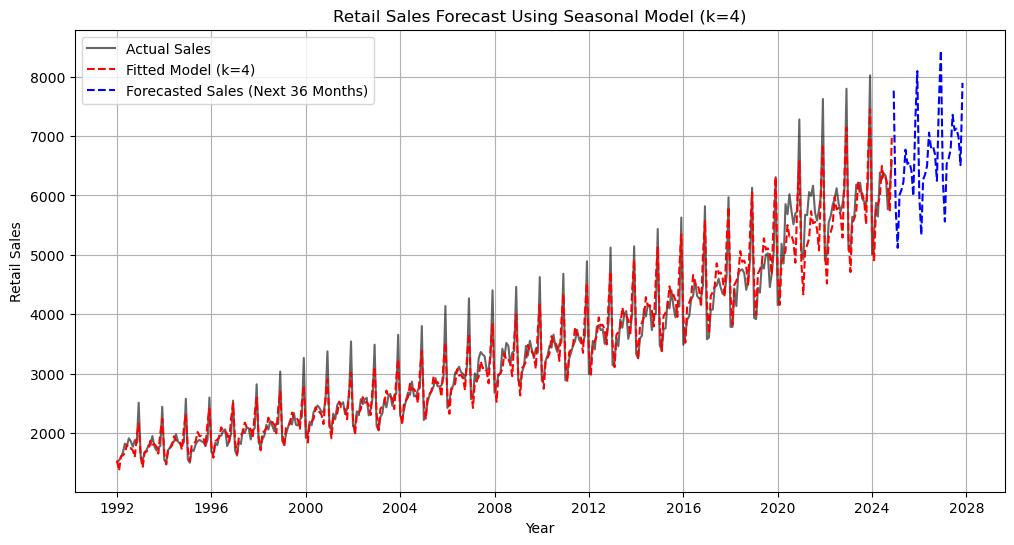

In [17]:
# Make predictions on training data
liq_data["fitted_seasonal"] = np.exp(model_seasonal.predict(X))  # Convert back from log scale

# Number of future months to predict
nf = 36

# Extend time index
t_future = np.arange(len(liq_data) + 1, len(liq_data) + 1 + nf)

# Create DataFrame for future values
future_data = pd.DataFrame({"t": t_future})

# Compute structural break indicators
future_data["I_t_geq_t0"] = (future_data["t"] >= t_0).astype(int)
future_data["t_I_t_geq_t0"] = future_data["t"] * future_data["I_t_geq_t0"]

# Compute seasonal components for k=4
for i in range(1, k + 1):
    future_data[f"cos_{i}"] = np.cos(2 * np.pi * i * future_data["t"] / 12)
    future_data[f"sin_{i}"] = np.sin(2 * np.pi * i * future_data["t"] / 12)

# Ensure columns match training data
X_future = sm.add_constant(future_data, has_constant="add")  # Ensure constant is present
X_future = X_future[X.columns]  # Match column order exactly

# Generate future predictions
log_pred = model_seasonal.predict(X_future)
pred_sales = np.exp(log_pred)  # Convert back from log scale
future_data["pred_sales"] = pred_sales

plt.figure(figsize=(12, 6))
plt.plot(liq_data["observation_date"], liq_data["sales"], label="Actual Sales", color="black", alpha=0.6) # Plot original sales data
plt.plot(liq_data["observation_date"], liq_data["fitted_seasonal"], label="Fitted Model (k=4)", color="red", linestyle="dashed") # Plot fitted values
future_dates = pd.date_range(start=liq_data["observation_date"].iloc[-1], periods=nf + 1, freq="MS")[1:] # Extend time axis for forecasted values
plt.plot(future_dates, future_data["pred_sales"], label="Forecasted Sales (Next 36 Months)", color="blue", linestyle="dashed") # Plot forecasted sales

# Labels and legend
plt.xlabel("Year")
plt.ylabel("Retail Sales")
plt.title(f"Retail Sales Forecast Using Seasonal Model (k={k})")
plt.legend()
plt.grid(True)
plt.show()

## Conclusion & Reasoning:

The predicted sales data for the next 36 months exhibit the same seasonal pattern as historical sales. The oscillations (waves) in sales occur at regular intervals, just like in past years, reflecting recurring seasonal trends in liquor sales. As prices of liquor increase, the total dollar value of sales rises, leading to higher peaks each year. In contrast, seasonal dips also become more pronounced, mirroring past behavior. The long-term trend in historical sales is upward, and the forecast maintains a similar growth trajectory. The forecast does not predict an unrealistic exponential increase but instead follows a steady, plausible growth path. This adjustment ensures that future predictions are based on post-pandemic trends rather than pre-pandemic behavior, making the forecast more reliable.

## 3a)

In [18]:
# Load the actual Yahoo dataset
yahoo = pd.read_csv("yahoo_query.csv")

# Drop the first row, which contains the misplaced column headers
yahoo = yahoo.iloc[1:].reset_index(drop=False)
print(yahoo)
# Rename columns for clarity
yahoo.columns = ["Month", "Search_Popularity"]

# Convert "Month" column to datetime format
yahoo["Month"] = pd.to_datetime(yahoo["Month"])
yahoo["Search_Popularity"] = pd.to_numeric(yahoo["Search_Popularity"])

       index Category: All categories
0    2004-01                       40
1    2004-02                       39
2    2004-03                       41
3    2004-04                       40
4    2004-05                       42
..       ...                      ...
248  2024-09                       18
249  2024-10                       18
250  2024-11                       17
251  2024-12                       17
252  2025-01                       16

[253 rows x 2 columns]


In [19]:
yahoo

,Month,Search_Popularity
0,2004-01-01,40
1,2004-02-01,39
2,2004-03-01,41
3,2004-04-01,40
4,2004-05-01,42
...,...,...
248,2024-09-01,18
249,2024-10-01,18
250,2024-11-01,17
251,2024-12-01,17


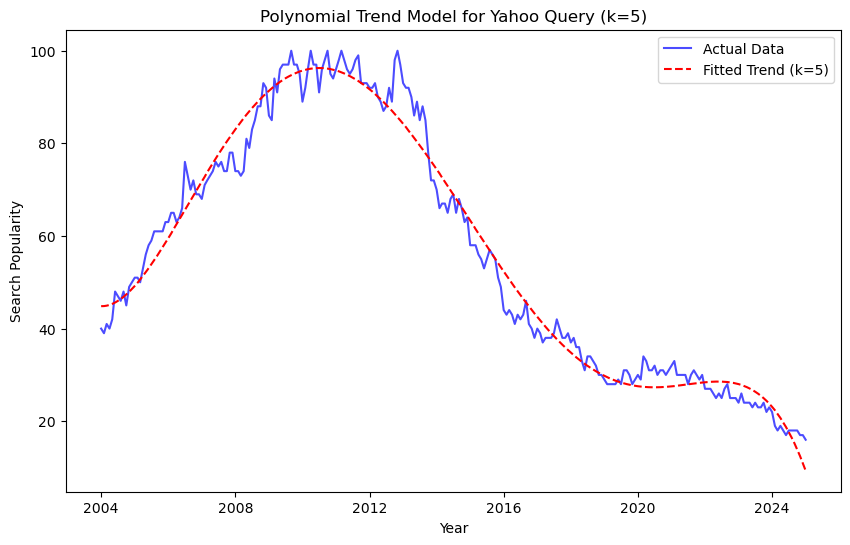

                            OLS Regression Results                            
Dep. Variable:      Search_Popularity   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     2021.
Date:                Sat, 03 May 2025   Prob (F-statistic):          4.36e-198
Time:                        23:17:47   Log-Likelihood:                -716.62
No. Observations:                 253   AIC:                             1445.
Df Residuals:                     247   BIC:                             1466.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         44.9063      1.625     27.632      0.0

In [20]:
# Create a numerical time index
yahoo["t"] = np.arange(1, len(yahoo) + 1)

# Choose polynomial degree k <= 5
k = 5
# Construct polynomial features
X = np.column_stack([yahoo["t"]**i for i in range(k + 1)])
X = sm.add_constant(X)  # Add intercept term

# Fit the polynomial regression model
y = yahoo["Search_Popularity"]
model = sm.OLS(y, X).fit()

# Generate predictions
yahoo["Fitted_Trend"] = model.predict(X)

# Plot actual data and fitted trend
plt.figure(figsize=(10, 6))
plt.plot(yahoo["Month"], yahoo["Search_Popularity"], label="Actual Data", color="blue", alpha=0.7)
plt.plot(yahoo["Month"], yahoo["Fitted_Trend"], label=f"Fitted Trend (k={k})", color="red", linestyle="dashed")
plt.xlabel("Year")
plt.ylabel("Search Popularity")
plt.title(f"Polynomial Trend Model for Yahoo Query (k={k})")
plt.legend()
plt.show()

# Print model summary
print(model.summary())

## Conclusion & Reasoning:

The $R^2$ value increases as $k$ increases, indicating a better fit to the data. For example, when $k=1$, $R^2$ is 0.502, meaning the lineaer trend only explains 50.2% of the variance. For $k=5$ is 0.9706, meaning the polynomial captures 97.6% of the variance, showing a much better fit. Thus, lower value of $k$ oversimplify the trend and fail to capture key inflection points. Higher values of $k$ capture the rise and decline of Yahoo's search popularity more effectively. In conclusion, Yahoo's search popularity grew during the early 2000s, peaked around 2010, and has been in decline since. The model with $k=5$ reflects this trajectory well.

## 3b)

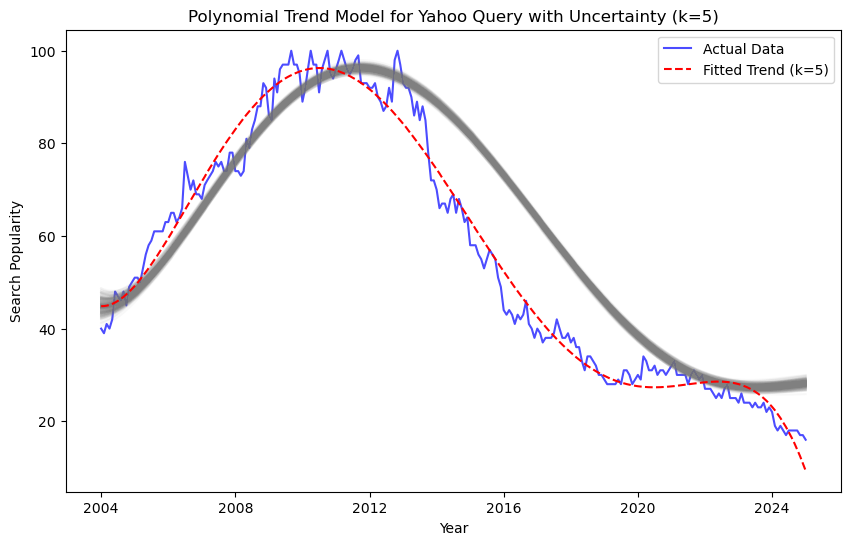

In [21]:
# Use the chosen k value (k=5)
k = 5

# Generate polynomial feature matrix for plotting
t_values = np.linspace(1, len(yahoo), 300)  # 300 points for smooth curve
X_poly = np.column_stack([t_values**i for i in range(1, k + 1)])
X_poly = sm.add_constant(X_poly)  # Add intercept term

# Sample 300 coefficient sets from the posterior distribution
coeff_samples = np.random.multivariate_normal(model.params, model.cov_params(), 300)

# Compute 300 sampled polynomial curves
plt.figure(figsize=(10, 6))
plt.plot(yahoo["Month"], yahoo["Search_Popularity"], label="Actual Data", color="blue", alpha=0.7)

for coeff in coeff_samples:
    sampled_trend = X_poly @ coeff[:k+1]  # Ensure it matches the original dataset size
    plt.plot(yahoo["Month"], sampled_trend[:len(yahoo["Month"])], color='gray', alpha=0.05)

# Plot the least squares polynomial estimate
plt.plot(yahoo["Month"], yahoo["Fitted_Trend"], label=f"Fitted Trend (k={k})", color="red", linestyle="dashed")

plt.xlabel("Year")
plt.ylabel("Search Popularity")
plt.title(f"Polynomial Trend Model for Yahoo Query with Uncertainty (k={k})")
plt.legend()
plt.show()

## Conclusion

The polynomial of degree $k=5$ fits the general shape of the observed data well, capturing both the rise and decline of search popularity over time. The gray uncertainty bands (posterior samples) illustrate the range of possible trends based on the model's coefficient uncertainty. The bands are tighter where data density is high and widen toward the end, where predictions are less certain. The declining trend in search popularity aligns with Yahoo’s decreasing relevance over the years. The uncertainty bands suggest the decline is relatively robust, though the exact trajectory varies slightly.